In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

%matplotlib inline
time_step = 30
input_num = 200
adjust_steps = 200

tau_i_input = 2 * np.ones(input_num)
tau_i_output = 2
tau_u = 5

i_input_decay = (1-1/tau_i_input)
i_output_decay = (1-1/tau_i_output)
u_decay = (1-1/tau_u)

In [3]:
def smooth(x, decay):
    if len(x.shape)==1:
        x = x.reshape(1,len(x))
    x = x.astype(float)
    x_smooth = np.zeros_like(x)
    x_smooth[:,0]=x[:,0]/(1/(1-decay))
    for i in range(len(x[0])-1):
        x_smooth[:,i+1] = x_smooth[:,i]*decay + x[:,i+1].astype(float)/(1/(1-decay))
    return x_smooth

In [4]:
def sigmoid(x,temp):
    exp = np.clip(-x/temp, -10, 10)
    return 1 / (1 + np.exp(exp))

In [5]:
output_record = np.zeros((adjust_steps, time_step))
delta_0_record = np.zeros((adjust_steps, time_step))
delta_record = np.zeros((adjust_steps, time_step))
grad_record = np.zeros((adjust_steps, time_step))

loss_record = np.zeros(adjust_steps)
tau_u_record = np.zeros(adjust_steps)
i_decay_record = np.zeros(adjust_steps)
u = np.zeros(time_step)
delta_u = np.zeros(time_step)
output = np.zeros(time_step)

In [6]:
partial_a_0 = np.zeros((time_step, time_step))
for t in range(time_step):
    if t > 0:
        partial_a_0[t] = partial_a_0[t - 1] - partial_a_0[t - 1] / tau_i_output
    partial_a_0[t, t] = 1/tau_i_output



0
100
200
300
400
0
100
200
300
400


Text(0.5, 1.0, 'Grad norm on each iteration during 500 rounds')

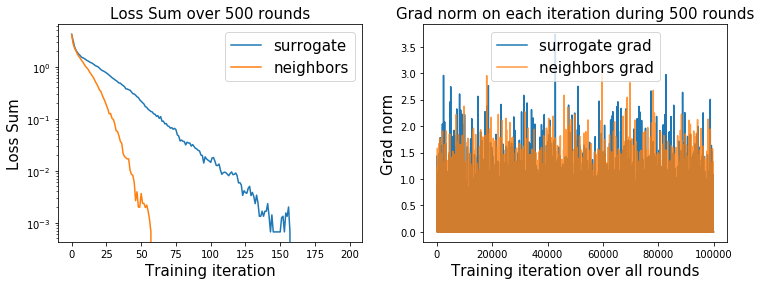

In [7]:
total_rounds = 500
threshold = 1
temp = 2
neighbor_grad_norm_record = []
neighbor_loss = np.zeros((total_rounds, adjust_steps))

for counter in range(total_rounds):
    if counter%100==0:
        print(counter)
    a = np.random.randint(0,20, size=(input_num,time_step))
    a = (a==0).astype(float)
    a_smooth = smooth(a, i_input_decay)
    a_smooth = stats.zscore(a_smooth)

    weights = (np.random.normal(size=input_num)) *0.1
    desired_output = np.random.randint(0,4,size=(1,time_step))
    desired_output = (desired_output == 0).astype(float)
    desired_output_smooth = smooth(desired_output, i_output_decay)

    tau_i_input = 2 * np.ones(input_num)
    tau_i_output = 2
    tau_u = 5

    i_input_decay = (1-1/tau_i_input)
    i_output_decay = (1-1/tau_i_output)
    u_decay = (1-1/tau_u)
    lr = 0.005
    for i in range(adjust_steps):
#         lr *= 0.996
        # Forward
        output = np.zeros(time_step)
        u[0] = delta_u[0] = u_temp = np.dot(weights, a_smooth[:,0])

        if u[0] > threshold:
            u_temp = 0
            output[0] = 1
        for j in range(time_step-1):
            u[j+1] = u_temp * u_decay + np.dot(weights,a_smooth[:,j+1])
            delta_u[j+1] = u[j+1] - u[j]
            if u[j+1] > threshold:
                u_temp = 0
                output[j+1] = 1
            else:
                u_temp = u[j+1]
        output_smooth = smooth(output, i_output_decay)

        # Record status
        output_record[i] = output
        # Backward
        # Calculate weight's gradient
        delta = (output_smooth-desired_output_smooth)[0]
#         delta_record[i] = delta

        loss_record[i] = np.sum((output_smooth-desired_output_smooth)[0]**2)

        # Find neighbors
        PSC_delta = np.zeros(time_step)
        project = np.zeros(time_step)
        for t in range(time_step):
            neighbor_output = output > 0
            near_by = True
            current_t = t
            while near_by == True:
                neighbor_output[current_t] = neighbor_output[current_t] ^ near_by
                current_t += 1
                if current_t == time_step:
                    break
                # New output of the previous time step
                nopp = neighbor_output[current_t - 1]
                # Membrane potential of the current time step
                mbp = u[current_t]
                near_by = near_by&\
                    ((near_by&(nopp==True)&((threshold<=mbp)&(mbp<(threshold+u_decay))))|\
                    (near_by&(nopp==False)&(((threshold-u_decay)<mbp)&(mbp<threshold))))
            neighbor_PSC = smooth(neighbor_output.astype('float'), i_output_decay)
            PSC_delta = neighbor_PSC - output_smooth
            project[t] = PSC_delta.dot(-delta)/np.linalg.norm(PSC_delta)

#         sig = sigmoid(u-threshold, temp)
        dist = 1/(np.abs(u-threshold)+1)
        grad = project * (output - 0.5) * 2 * dist#(sig*(1-sig))/temp
        
        neighbor_grad_norm_record += [np.sqrt(np.sum(grad**2))]
        
        if np.sqrt(np.sum(grad**2)) == np.nan:
            print(grad)
            
        grad_w = grad.dot(a_smooth.T)

        grad_record[i] = grad
        # Move Step
        weights = weights - lr * grad_w
#     print(loss_record)
    neighbor_loss[counter] = loss_record

temp = 3
surro_grad_norm_record = []
sig_loss = np.zeros((total_rounds, adjust_steps))
for counter in range(total_rounds):
    if counter%100==0:
        print(counter)
    a = np.random.randint(0,20, size=(input_num,time_step))
    a = (a==0).astype(float)
    a_smooth = smooth(a, i_input_decay)
    a_smooth = stats.zscore(a_smooth)
    weights = (np.random.normal(size=input_num)) *0.1
    desired_output = np.random.randint(0,4,size=(1,time_step))
    desired_output = (desired_output == 0).astype(float)
    desired_output_smooth = smooth(desired_output, i_output_decay)

    tau_i_input = 2 * np.ones(input_num)
    tau_i_output = 2
    tau_u = 5

    i_input_decay = (1-1/tau_i_input)
    i_output_decay = (1-1/tau_i_output)
    u_decay = (1-1/tau_u)
    lr = 0.005
    for i in range(adjust_steps):
#         lr *= 0.996
        # Forward
        output = np.zeros(time_step)
        u[0] = delta_u[0] = u_temp = np.dot(weights, a_smooth[:,0])

        if u[0] > threshold:
            u_temp = 0
            output[0] = 1
        for j in range(time_step-1):
            u[j+1] = u_temp * u_decay + np.dot(weights,a_smooth[:,j+1])
            delta_u[j+1] = u[j+1] - u[j]
            if u[j+1] > threshold:
                u_temp = 0
                output[j+1] = 1
            else:
                u_temp = u[j+1]
        output_smooth = smooth(output, i_output_decay)

        # Record status
        output_record[i] = output
        # Backward
        # Calculate weight's gradient
        delta = (output_smooth-desired_output_smooth)[0].dot(partial_a_0)
#         delta_record[i] = delta

        loss_record[i] = np.sum((output_smooth-desired_output_smooth)[0]**2)
        

        sig = sigmoid(u-threshold, temp)
        grad = delta * (sig*(1-sig))/temp * 5
        
        
        for g in range(len(grad)-2, -1, -1):
            grad[g] += grad[g+1] * u_decay * (1 - output[g])

        surro_grad_norm_record += [np.sqrt(np.sum(grad**2))]
        if np.sqrt(np.sum(grad**2)) == np.nan:
            print(grad)

        grad_w = grad.dot(a_smooth.T)

        grad_record[i] = grad
        # Move Step
        weights = weights - lr * grad_w
    sig_loss[counter] = loss_record
plt.figure(figsize=(12,4))
sig = np.mean(sig_loss,axis=0)
nei = np.mean(neighbor_loss,axis=0)
sig_std = np.std(sig_loss,axis=0)
nei_std = np.std(neighbor_loss,axis=0)
plt.subplot(121)
plt.plot(sig, label='surrogate')
plt.plot(nei, label='neighbors')
# plt.fill_between(range(adjust_steps), sig - sig_std, sig+sig_std, color='blue', alpha=0.2)
# plt.fill_between(range(adjust_steps), nei - nei_std, nei+nei_std, color='orange', alpha=0.2)
plt.yscale('log')
plt.legend(fontsize=15)
plt.title('Loss Sum over 500 rounds', fontsize=15)
plt.ylabel('Loss Sum', fontsize=15)
plt.xlabel('Training iteration', fontsize=15)

plt.subplot(122)
plt.plot(surro_grad_norm_record, label='surrogate grad')
plt.plot(neighbor_grad_norm_record, label='neighbors grad',alpha=.8)
plt.legend(fontsize=15)
plt.ylabel('Grad norm', fontsize=15)
plt.xlabel('Training iteration over all rounds', fontsize=15)
plt.title('Grad norm on each iteration during 500 rounds', fontsize=15)

In [21]:
print(list(nei).index(0))

58


Text(0.5, 1.0, 'Grad norm on each iteration')

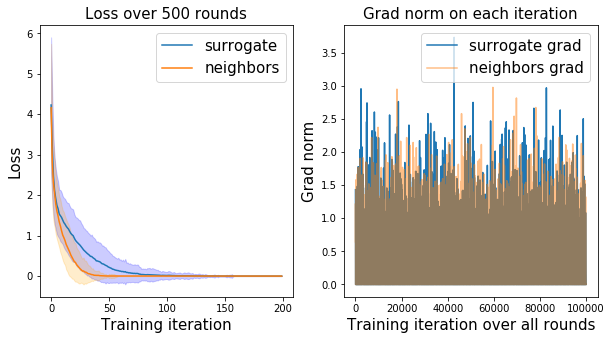

In [12]:
plt.figure(figsize=(10,5))
sig = np.mean(sig_loss,axis=0)
nei = np.mean(neighbor_loss,axis=0)
sig_std = np.std(sig_loss,axis=0)
nei_std = np.std(neighbor_loss,axis=0)
plt.subplot(121)
plt.plot(sig, label='surrogate')
plt.plot(nei, label='neighbors')
plt.fill_between(range(adjust_steps), sig - sig_std, sig+sig_std, color='blue', alpha=0.2)
plt.fill_between(range(adjust_steps), nei - nei_std, nei+nei_std, color='orange', alpha=0.2)
# plt.yscale('log')
plt.legend(fontsize=15)
plt.title('Loss over 500 rounds', fontsize=15)
plt.ylabel('Loss', fontsize=15)
plt.xlabel('Training iteration', fontsize=15)

plt.subplot(122)
plt.plot(surro_grad_norm_record, label='surrogate grad')
plt.plot(neighbor_grad_norm_record, label='neighbors grad',alpha=.5)
plt.legend(fontsize=15)
plt.ylabel('Grad norm', fontsize=15)
plt.xlabel('Training iteration over all rounds', fontsize=15)
plt.title('Grad norm on each iteration', fontsize=15)

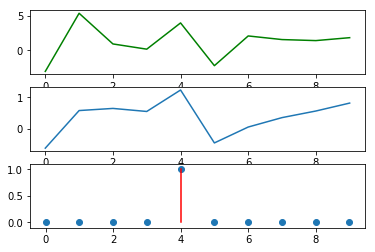

In [155]:
import matplotlib.pyplot as plt
%matplotlib inline
a = (np.random.uniform(-1,1,size=(10))+0.3)*5
# w = np.random.uniform(-1,1,size=(10))+0.3
u_temp = 0
decay = 0.8
U = np.zeros(10)
S = np.zeros(10)
for i in range(10):
    U[i] = u_temp * decay + a[i] * 0.2
    if U[i]>1:
        u_temp = 0
        S[i] = 1
    else:
        u_temp = U[i]
plt.figure()
plt.subplot(3,1,1)
plt.plot(a,c='g')
plt.subplot(3,1,2)
plt.plot(U)
plt.subplot(3,1,3)
plt.scatter(range(10),S)
for i in range(10):
    plt.plot((i,i),(0,S[i]),c='r')

Text(0.5, 0, 'Training iteration')

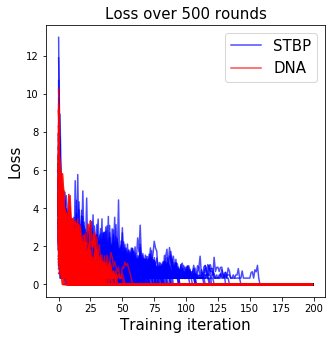

In [17]:
plt.figure(figsize=(5,5))
for i in range(len(sig_loss)):
    plt.plot(sig_loss[i],c='b',alpha=0.7)
    plt.plot(neighbor_loss[i],c='r',alpha=0.7)
for i in range(len(sig_loss)):
    plt.plot(neighbor_loss[i],c='r',alpha=0.7)
plt.legend(['STBP','DNA'], fontsize=15)
plt.title('Loss over 500 rounds', fontsize=15)
plt.ylabel('Loss', fontsize=15)
plt.xlabel('Training iteration', fontsize=15)